In [1]:
import numpy as np
import torch
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from plot_functions import *

# Load Posterior Samples

In [2]:
name = "NPE_C_maf_8_4"

In [3]:
# --- Load simulated data ---
alpha_IMF_obs = np.load(f"data/alpha_IMF_obs_{name}.npy")
log10_N_Ia_obs = np.load(f"data/log10_N_Ia_obs_{name}.npy")

In [4]:
simulations = 1000
N_stars = 200
global_params = np.array([[-2.3, -2.89]])

# Predict Multistar Posterior
We can compute the posterior for a single star from the samples created in ```03_sample_from_posterior.ipynb```. <br>
Because of the central limit theorem, we can write the posterior for a single star as a multivariate Gaussian. <br>
This gives us the mean and covariance of $\alpha_{IMF}$ and $log{N_{Ia}}$ for one observation. <br>

We can then combine the posterior for multiple stars to get the posterior for the entire dataset. <br>
$$ 
\begin{align*}
P(\theta| data) &\propto \prod_{i=1}^{N_{stars}} P(\theta| obs_i) \\ \\
&\propto \prod_{i=1}^{N_{stars}} \exp\left(-\frac{1}{2} \frac{(\theta-\mu_i)^2}{\sigma_i^2}\right)
\end{align*} 
$$

This is a product of Gaussians, so the posterior for the entire dataset is also a Gaussian with mean $\mathbf{\mu}$ and variance $\mathbf{\sigma}$. <br>
$$
\begin{align*}
\mathbf{\mu} &= \frac{\sum_{i=1}^{N_{stars}} \frac{\mu_i}{\sigma_i^2}}{\sum_{i=1}^{N_{stars}} \frac1{\sigma_i^2}} \\ \\
\mathbf{\sigma}^2 &= \frac1 {\sum_{i=1}^{N_{stars}} \frac1{\sigma_i^2}}
\end{align*}
$$

In [21]:
data = np.stack([alpha_IMF_obs, log10_N_Ia_obs],2)

In [70]:

from scipy.stats import norm, gaussian_kde, multivariate_normal
from scipy import optimize

def map_kde(samples):
    """Find the joint mode of the multivariate distribution"""
    s = samples
    kde = gaussian_kde(s.T)  # KDE expects (n_dims, n_samples)
    
    # Start optimization from the mean
    initial_guess = np.mean(s, axis=0)
    
    # Use full minimize with multiple dimensions
    result = optimize.minimize(lambda x: -kde(x.reshape(-1, 1)), initial_guess)
    cov = kde.covariance

    return result.x, cov

In [71]:
res = [map_kde(data[i]) for i in range(len(data))]

In [153]:
data.mean(1).mean(0), data.std(1).mean(0)/ np.sqrt(len(data))

(array([-2.289532 , -2.8816204], dtype=float32),
 array([0.00559313, 0.00816852], dtype=float32))

In [206]:
mean_n = np.zeros_like(res[0][0])
inv_cov = np.zeros_like(res[0][1])
prior_mean = np.array([-2.3, -2.89])
prior_cov = np.array([[0.3**2, 0], [0, 0.3**2]])

for i in range(len(res)):
	mean = res[i][0]
	cov = np.linalg.inv(res[i][1])

	mean_n += cov@mean
	inv_cov += cov

post_cov = inv_cov - (199*np.linalg.inv(prior_cov))
post_cov = np.linalg.inv(post_cov)

post_mean = post_cov@(mean_n - 199*(np.linalg.inv(prior_cov)@prior_mean))


In [207]:
post_mean, np.sqrt(np.diag(post_cov))

(array([-2.28928513, -2.86961958]), array([0.00174903, 0.0024839 ]))

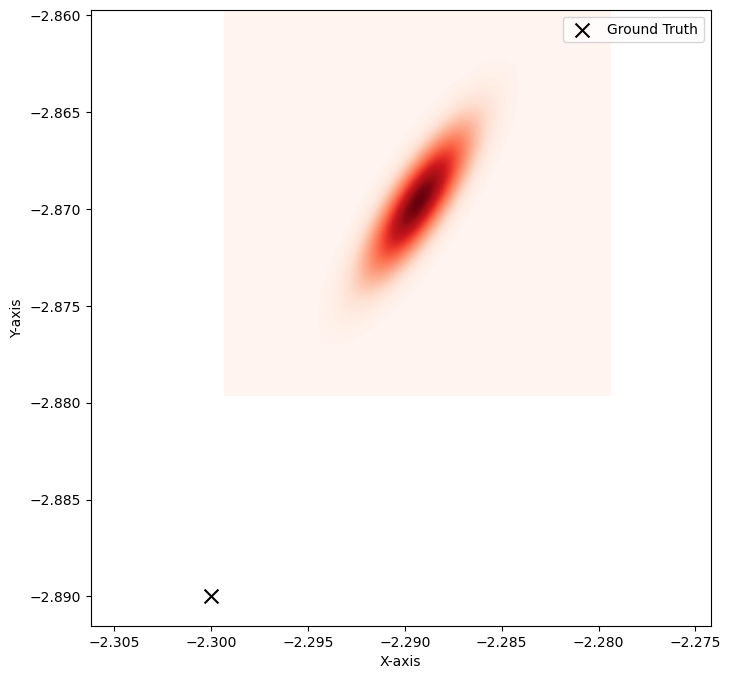

In [208]:
# Create grid of (x, y) points
X, Y = np.mgrid[post_mean[0]-0.01: post_mean[0]+0.01: 0.0001, post_mean[1]-0.01: post_mean[1]+0.01: 0.0001]
pos = np.dstack((X, Y))

# Create the multivariate Gaussian distribution
rv = multivariate_normal(mean=post_mean, cov=post_cov)
Z = rv.pdf(pos)

# Plot
plt.figure(figsize=(8,8))
plt.contourf(X, Y, Z, levels=100, cmap='Reds')

plt.scatter(prior_mean[0], prior_mean[1], color='k', marker='x', s=100, label='Ground Truth')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.axis('equal')
plt.show()

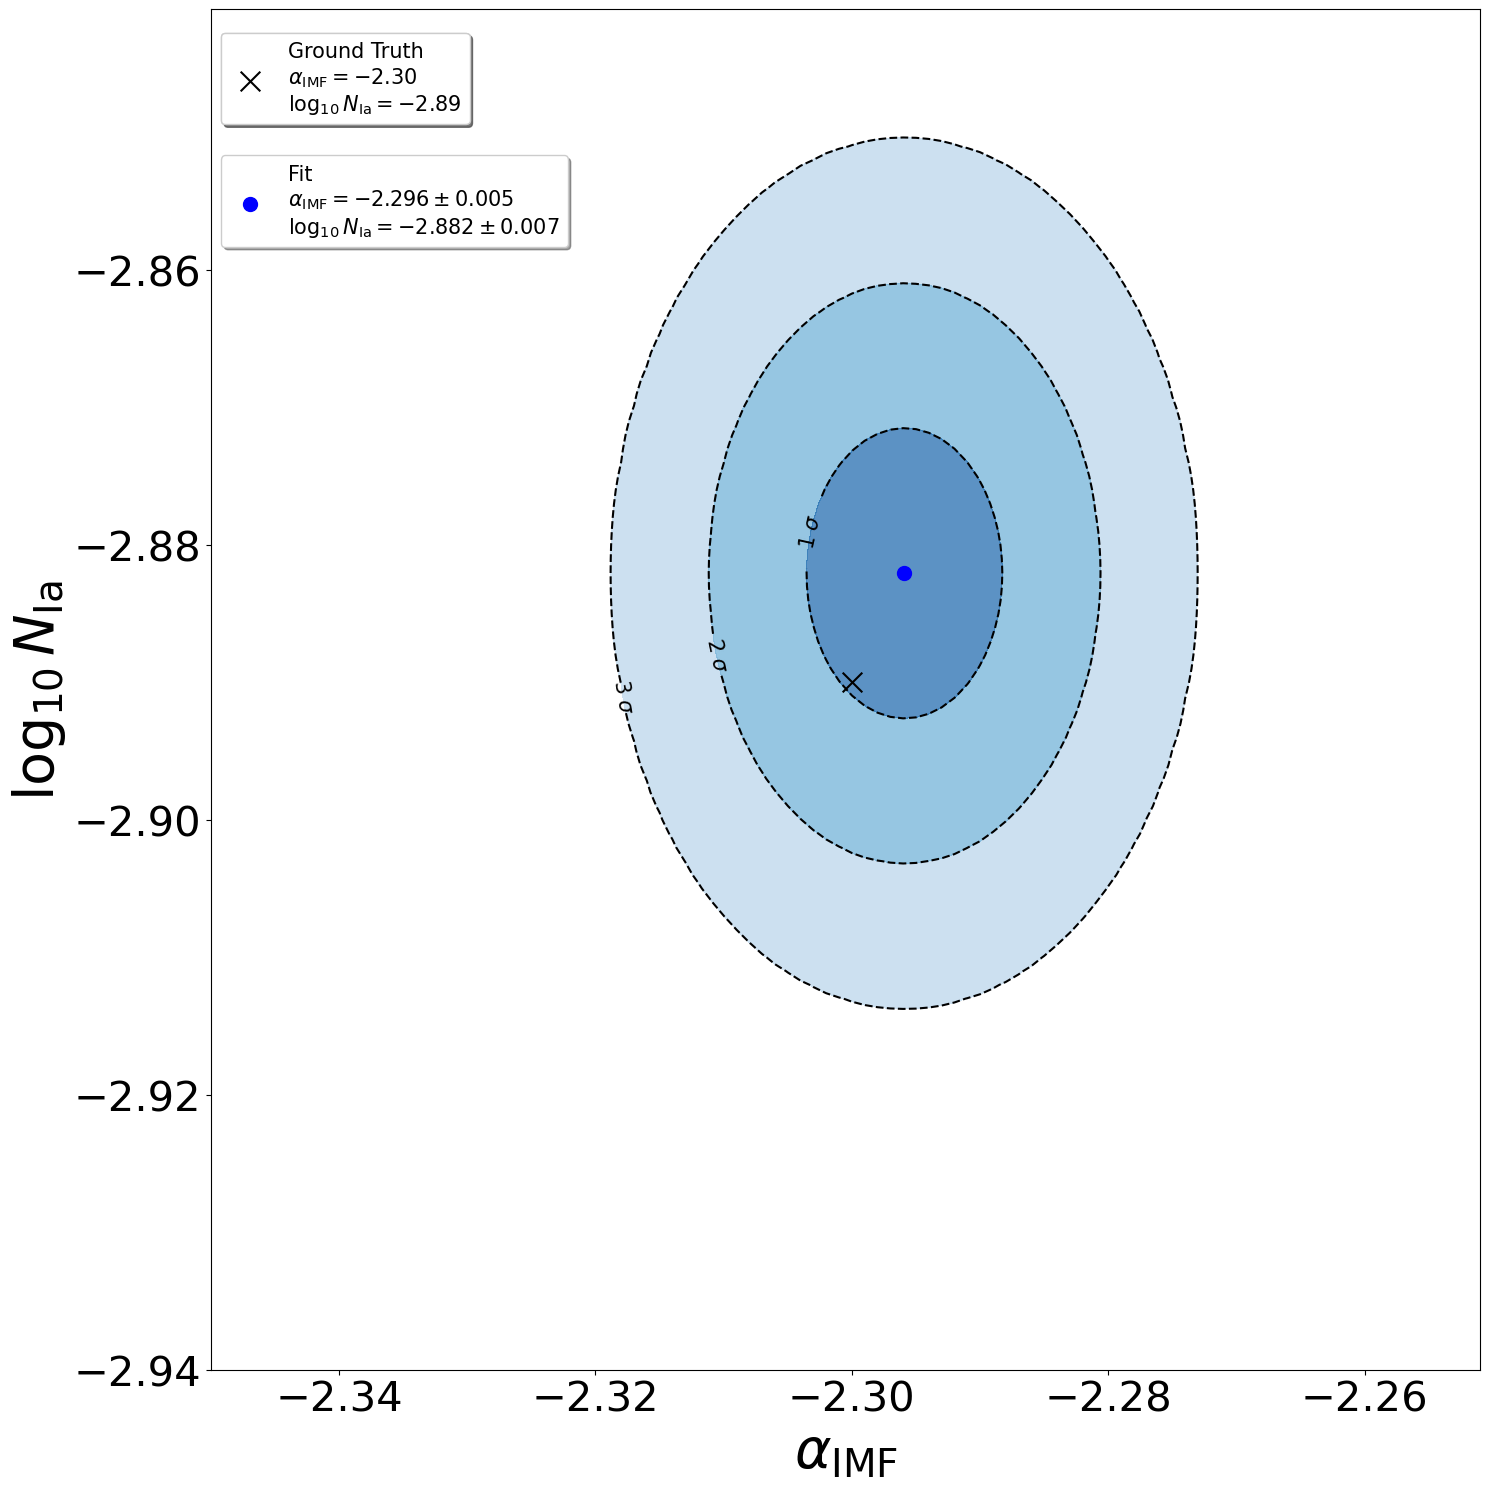

In [5]:
gaussian_posterior_plot(alpha_IMF_obs, log10_N_Ia_obs, global_params, title="CHEMPY TNG yields")

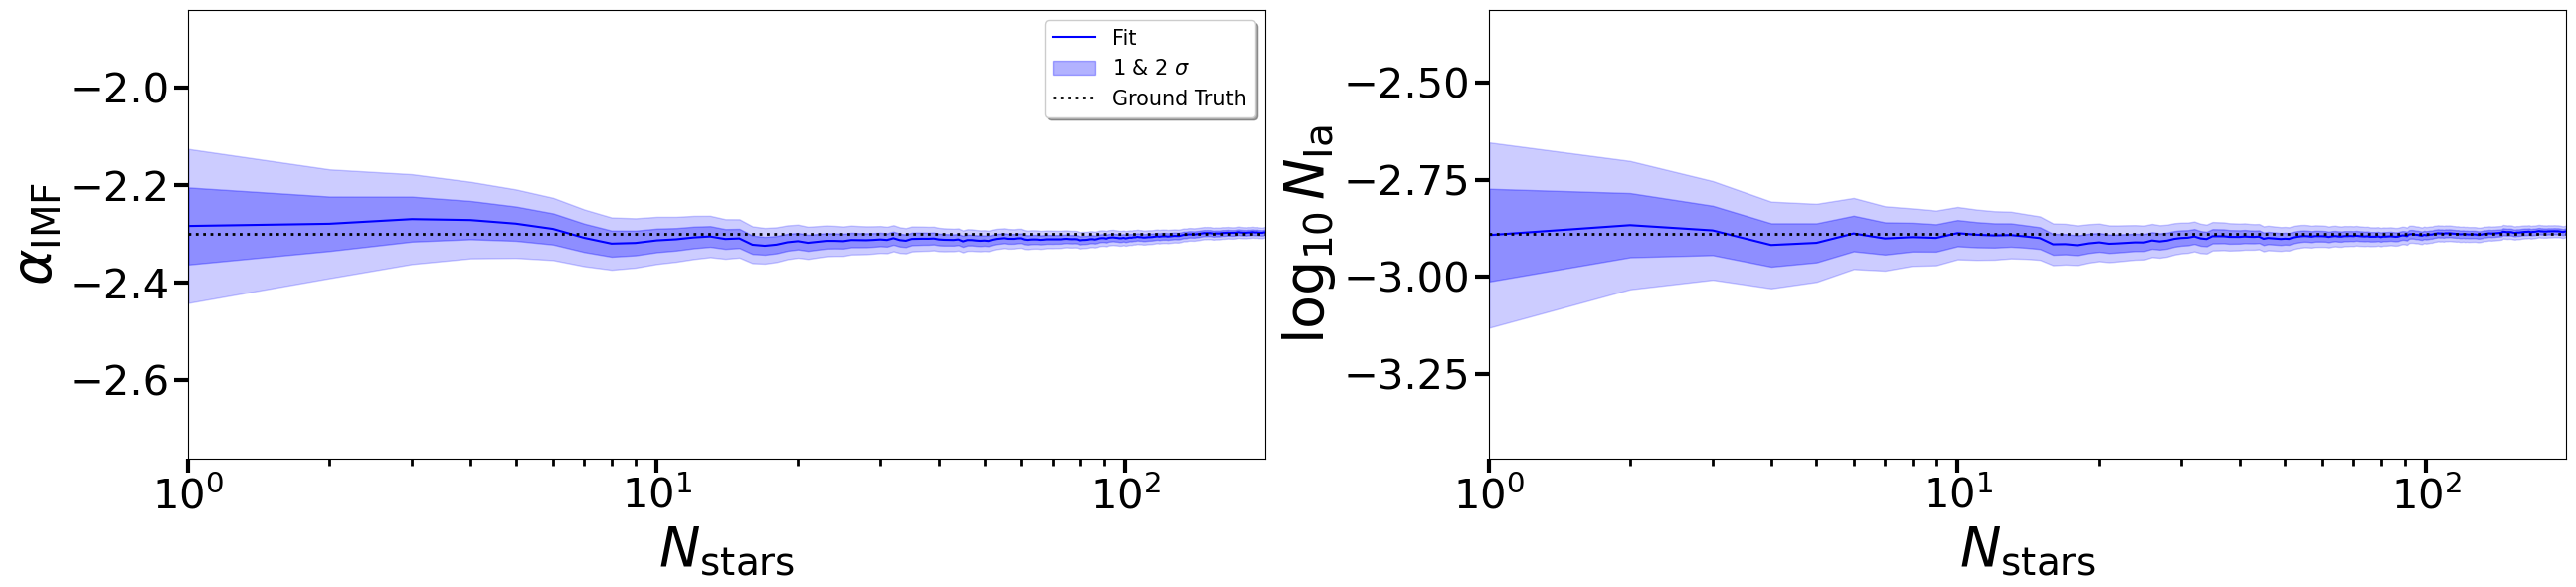

In [6]:
stars = np.arange(1,200)
n_stars_plot(alpha_IMF_obs, log10_N_Ia_obs, global_params, "CHEMPY TNG yields N_star", stars)

## Compare to HMC

In [7]:
dat = np.load('data/chempy_data_paper/Inference_Output.npz', allow_pickle=True)

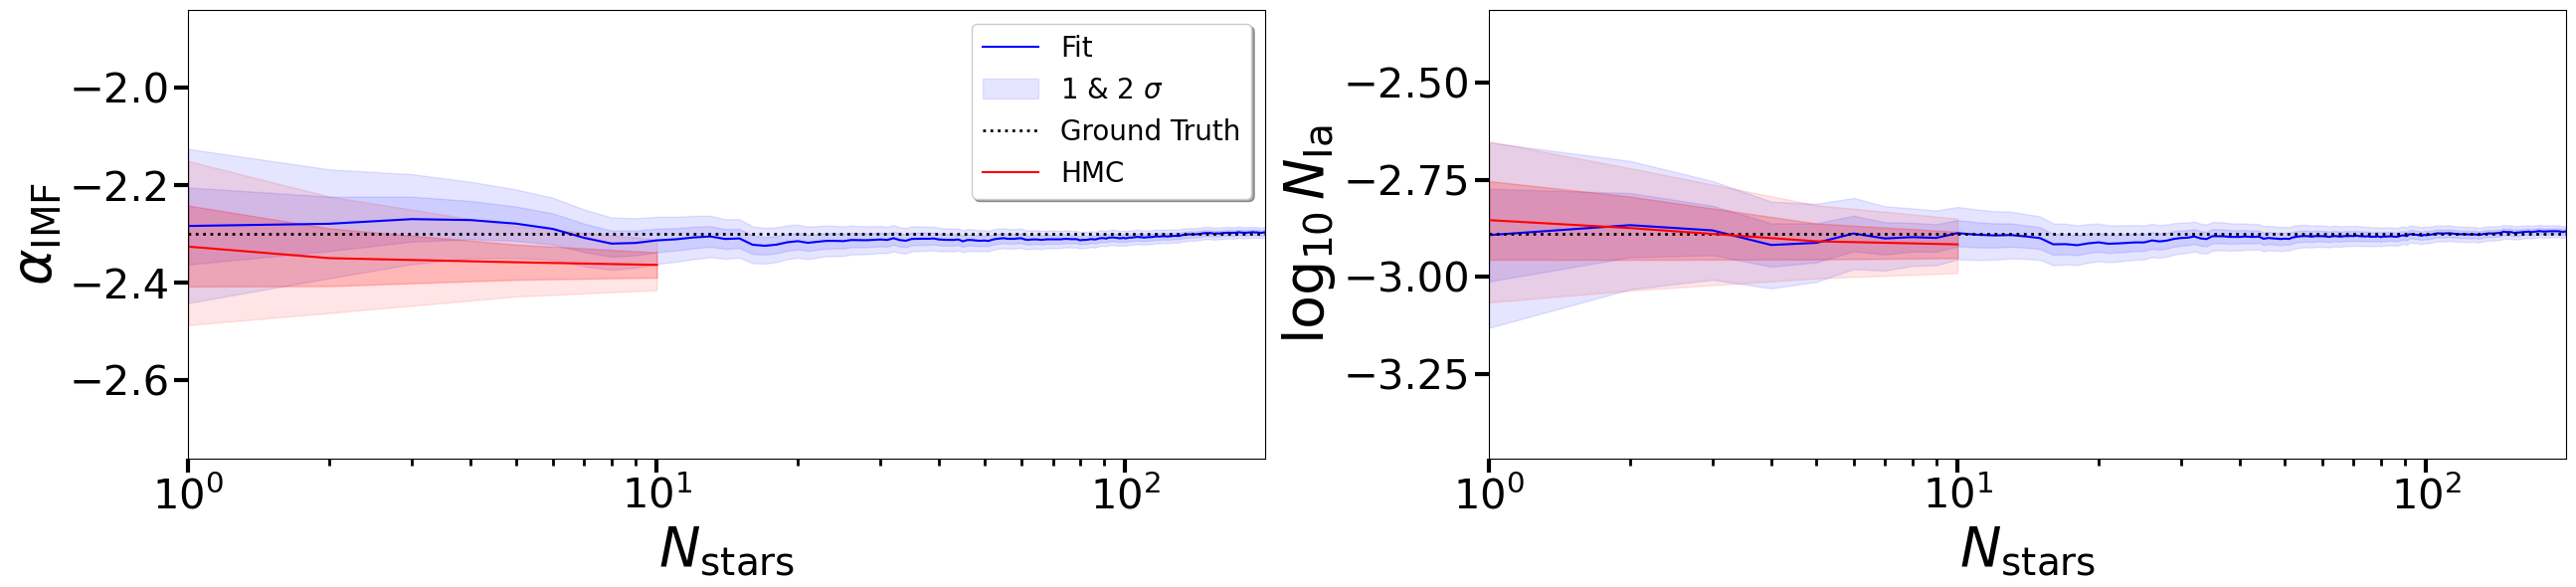

In [209]:
stars = np.arange(1,200)
n_stars_plot_comp(alpha_IMF_obs, log10_N_Ia_obs, global_params, dat, "CHEMPY TNG yields N_star comp", stars)